# Simple NN for survival prediction on the Titanic

author: Witalis Domitrz <witekdomitrz@gmail.com>

## Downloading the data

In [3]:
!wget http://students.mimuw.edu.pl/~wd393711/iml/titanic.zip
!unzip -o titanic.zip
!rm titanic.zip

zsh:1: command not found: wget
unzip:  cannot find or open titanic.zip, titanic.zip.zip or titanic.zip.ZIP.
rm: titanic.zip: No such file or directory


## Imports

In [8]:
# %tensorflow_version 2.x
import numpy as np 
import pandas as pd
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import Callback

2023-11-01 22:55:05.578223: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare the data

In [11]:
X_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
Y_columns = ['Survived']

def load_data(fn):
    return pd.read_csv(fn).set_index('PassengerId')

def to_array(data):
    return pd.get_dummies(data).astype(dtype='float32').values

def split_to_x_y(data):
    return to_array(data[X_columns]), to_array(data[Y_columns])

def get_data():
    train = load_data('./train.csv')
    test = load_data('./gender_submission.csv').join(load_data('./test.csv'))    

    train['is_train'] = True
    test['is_train'] = False
    data = pd.concat([train, test])

    # Replace missing values with mean
    data.fillna(data.mean(), inplace=True)

    # Split test and train
    train = data[data['is_train']]
    test = data[data['is_train'] == False]

    return split_to_x_y(train), split_to_x_y(test)

In [12]:
(train_x, train_y), (test_x, test_y) = get_data()

TypeError: Could not convert ['Braund, Mr. Owen HarrisCumings, Mrs. John Bradley (Florence Briggs Thayer)Heikkinen, Miss. LainaFutrelle, Mrs. Jacques Heath (Lily May Peel)Allen, Mr. William HenryMoran, Mr. JamesMcCarthy, Mr. Timothy JPalsson, Master. Gosta LeonardJohnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)Nasser, Mrs. Nicholas (Adele Achem)Sandstrom, Miss. Marguerite RutBonnell, Miss. ElizabethSaundercock, Mr. William HenryAndersson, Mr. Anders JohanVestrom, Miss. Hulda Amanda AdolfinaHewlett, Mrs. (Mary D Kingcome) Rice, Master. EugeneWilliams, Mr. Charles EugeneVander Planke, Mrs. Julius (Emelia Maria Vandemoortele)Masselmani, Mrs. FatimaFynney, Mr. Joseph JBeesley, Mr. LawrenceMcGowan, Miss. Anna "Annie"Sloper, Mr. William ThompsonPalsson, Miss. Torborg DaniraAsplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson)Emir, Mr. Farred ChehabFortune, Mr. Charles AlexanderO\'Dwyer, Miss. Ellen "Nellie"Todoroff, Mr. LalioUruchurtu, Don. Manuel ESpencer, Mrs. William Augustus (Marie Eugenie)Glynn, Miss. Mary AgathaWheadon, Mr. Edward HMeyer, Mr. Edgar JosephHolverson, Mr. Alexander OskarMamee, Mr. HannaCann, Mr. Ernest CharlesVander Planke, Miss. Augusta MariaNicola-Yarred, Miss. JamilaAhlin, Mrs. Johan (Johanna Persdotter Larsson)Turpin, Mrs. William John Robert (Dorothy Ann Wonnacott)Kraeff, Mr. TheodorLaroche, Miss. Simonne Marie Anne AndreeDevaney, Miss. Margaret DeliaRogers, Mr. William JohnLennon, Mr. DenisO\'Driscoll, Miss. BridgetSamaan, Mr. YoussefArnold-Franchi, Mrs. Josef (Josefine Franchi)Panula, Master. Juha NiiloNosworthy, Mr. Richard CaterHarper, Mrs. Henry Sleeper (Myna Haxtun)Faunthorpe, Mrs. Lizzie (Elizabeth Anne Wilkinson)Ostby, Mr. Engelhart CorneliusWoolner, Mr. HughRugg, Miss. EmilyNovel, Mr. MansouerWest, Miss. Constance MiriumGoodwin, Master. William FrederickSirayanian, Mr. OrsenIcard, Miss. AmelieHarris, Mr. Henry BirkhardtSkoog, Master. HaraldStewart, Mr. Albert AMoubarek, Master. GeriosNye, Mrs. (Elizabeth Ramell)Crease, Mr. Ernest JamesAndersson, Miss. Erna AlexandraKink, Mr. VincenzJenkin, Mr. Stephen CurnowGoodwin, Miss. Lillian AmyHood, Mr. Ambrose JrChronopoulos, Mr. ApostolosBing, Mr. LeeMoen, Mr. Sigurd HansenStaneff, Mr. IvanMoutal, Mr. Rahamin HaimCaldwell, Master. Alden GatesDowdell, Miss. ElizabethWaelens, Mr. AchilleSheerlinck, Mr. Jan BaptistMcDermott, Miss. Brigdet DeliaCarrau, Mr. Francisco MIlett, Miss. BerthaBackstrom, Mrs. Karl Alfred (Maria Mathilda Gustafsson)Ford, Mr. William NealSlocovski, Mr. Selman FrancisFortune, Miss. Mabel HelenCelotti, Mr. FrancescoChristmann, Mr. EmilAndreasson, Mr. Paul EdvinChaffee, Mr. Herbert FullerDean, Mr. Bertram FrankCoxon, Mr. DanielShorney, Mr. Charles JosephGoldschmidt, Mr. George BGreenfield, Mr. William BertramDoling, Mrs. John T (Ada Julia Bone)Kantor, Mr. SinaiPetranec, Miss. MatildaPetroff, Mr. Pastcho ("Pentcho")White, Mr. Richard FrasarJohansson, Mr. Gustaf JoelGustafsson, Mr. Anders VilhelmMionoff, Mr. StoytchoSalkjelsvik, Miss. Anna KristineMoss, Mr. Albert JohanRekic, Mr. TidoMoran, Miss. BerthaPorter, Mr. Walter ChamberlainZabour, Miss. HileniBarton, Mr. David JohnJussila, Miss. KatriinaAttalah, Miss. MalakePekoniemi, Mr. EdvardConnors, Mr. PatrickTurpin, Mr. William John RobertBaxter, Mr. Quigg EdmondAndersson, Miss. Ellis Anna MariaHickman, Mr. Stanley GeorgeMoore, Mr. Leonard CharlesNasser, Mr. NicholasWebber, Miss. SusanWhite, Mr. Percival WaylandNicola-Yarred, Master. EliasMcMahon, Mr. MartinMadsen, Mr. Fridtjof ArnePeter, Miss. AnnaEkstrom, Mr. JohanDrazenoic, Mr. JozefCoelho, Mr. Domingos FernandeoRobins, Mrs. Alexander A (Grace Charity Laury)Weisz, Mrs. Leopold (Mathilde Francoise Pede)Sobey, Mr. Samuel James HaydenRichard, Mr. EmileNewsom, Miss. Helen MonypenyFutrelle, Mr. Jacques HeathOsen, Mr. Olaf ElonGiglio, Mr. VictorBoulos, Mrs. Joseph (Sultana)Nysten, Miss. Anna SofiaHakkarainen, Mrs. Pekka Pietari (Elin Matilda Dolck)Burke, Mr. JeremiahAndrew, Mr. Edgardo SamuelNicholls, Mr. Joseph CharlesAndersson, Mr. August Edvard ("Wennerstrom")Ford, Miss. Robina Maggie "Ruby"Navratil, Mr. Michel ("Louis M Hoffman")Byles, Rev. Thomas Roussel DavidsBateman, Rev. Robert JamesPears, Mrs. Thomas (Edith Wearne)Meo, Mr. Alfonzovan Billiard, Mr. Austin BlylerOlsen, Mr. Ole MartinWilliams, Mr. Charles DuaneGilnagh, Miss. Katherine "Katie"Corn, Mr. HarrySmiljanic, Mr. MileSage, Master. Thomas HenryCribb, Mr. John HatfieldWatt, Mrs. James (Elizabeth "Bessie" Inglis Milne)Bengtsson, Mr. John ViktorCalic, Mr. JovoPanula, Master. Eino ViljamiGoldsmith, Master. Frank John William "Frankie"Chibnall, Mrs. (Edith Martha Bowerman)Skoog, Mrs. William (Anna Bernhardina Karlsson)Baumann, Mr. John DLing, Mr. LeeVan der hoef, Mr. WyckoffRice, Master. ArthurJohnson, Miss. Eleanor IleenSivola, Mr. Antti WilhelmSmith, Mr. James ClinchKlasen, Mr. Klas AlbinLefebre, Master. Henry ForbesIsham, Miss. Ann ElizabethHale, Mr. ReginaldLeonard, Mr. LionelSage, Miss. Constance GladysPernot, Mr. ReneAsplund, Master. Clarence Gustaf HugoBecker, Master. Richard FKink-Heilmann, Miss. Luise GretchenRood, Mr. Hugh RoscoeO\'Brien, Mrs. Thomas (Johanna "Hannah" Godfrey)Romaine, Mr. Charles Hallace ("Mr C Rolmane")Bourke, Mr. JohnTurcin, Mr. StjepanPinsky, Mrs. (Rosa)Carbines, Mr. WilliamAndersen-Jensen, Miss. Carla Christine NielsineNavratil, Master. Michel MBrown, Mrs. James Joseph (Margaret Tobin)Lurette, Miss. EliseMernagh, Mr. RobertOlsen, Mr. Karl Siegwart AndreasMadigan, Miss. Margaret "Maggie"Yrois, Miss. Henriette ("Mrs Harbeck")Vande Walle, Mr. Nestor CyrielSage, Mr. FrederickJohanson, Mr. Jakob AlfredYouseff, Mr. GeriousCohen, Mr. Gurshon "Gus"Strom, Miss. Telma MatildaBackstrom, Mr. Karl AlfredAlbimona, Mr. Nassef CassemCarr, Miss. Helen "Ellen"Blank, Mr. HenryAli, Mr. AhmedCameron, Miss. Clear AnniePerkin, Mr. John HenryGivard, Mr. Hans KristensenKiernan, Mr. PhilipNewell, Miss. MadeleineHonkanen, Miss. EliinaJacobsohn, Mr. Sidney SamuelBazzani, Miss. AlbinaHarris, Mr. WalterSunderland, Mr. Victor FrancisBracken, Mr. James HGreen, Mr. George HenryNenkoff, Mr. ChristoHoyt, Mr. Frederick MaxfieldBerglund, Mr. Karl Ivar SvenMellors, Mr. William JohnLovell, Mr. John Hall ("Henry")Fahlstrom, Mr. Arne JonasLefebre, Miss. MathildeHarris, Mrs. Henry Birkhardt (Irene Wallach)Larsson, Mr. Bengt EdvinSjostedt, Mr. Ernst AdolfAsplund, Miss. Lillian GertrudLeyson, Mr. Robert William NormanHarknett, Miss. Alice PhoebeHold, Mr. StephenCollyer, Miss. Marjorie "Lottie"Pengelly, Mr. Frederick WilliamHunt, Mr. George HenryZabour, Miss. ThamineMurphy, Miss. Katherine "Kate"Coleridge, Mr. Reginald CharlesMaenpaa, Mr. Matti AlexanteriAttalah, Mr. SleimanMinahan, Dr. William EdwardLindahl, Miss. Agda Thorilda ViktoriaHamalainen, Mrs. William (Anna)Beckwith, Mr. Richard LeonardCarter, Rev. Ernest CourtenayReed, Mr. James GeorgeStrom, Mrs. Wilhelm (Elna Matilda Persson)Stead, Mr. William ThomasLobb, Mr. William ArthurRosblom, Mrs. Viktor (Helena Wilhelmina)Touma, Mrs. Darwis (Hanne Youssef Razi)Thorne, Mrs. Gertrude MaybelleCherry, Miss. GladysWard, Miss. AnnaParrish, Mrs. (Lutie Davis)Smith, Mr. ThomasAsplund, Master. Edvin Rojj FelixTaussig, Mr. EmilHarrison, Mr. WilliamHenry, Miss. DeliaReeves, Mr. DavidPanula, Mr. Ernesti ArvidPersson, Mr. Ernst UlrikGraham, Mrs. William Thompson (Edith Junkins)Bissette, Miss. AmeliaCairns, Mr. AlexanderTornquist, Mr. William HenryMellinger, Mrs. (Elizabeth Anne Maidment)Natsch, Mr. Charles HHealy, Miss. Hanora "Nora"Andrews, Miss. Kornelia TheodosiaLindblom, Miss. Augusta CharlottaParkes, Mr. Francis "Frank"Rice, Master. EricAbbott, Mrs. Stanton (Rosa Hunt)Duane, Mr. FrankOlsson, Mr. Nils Johan Goranssonde Pelsmaeker, Mr. AlfonsDorking, Mr. Edward ArthurSmith, Mr. Richard WilliamStankovic, Mr. Ivande Mulder, Mr. TheodoreNaidenoff, Mr. PenkoHosono, Mr. MasabumiConnolly, Miss. KateBarber, Miss. Ellen "Nellie"Bishop, Mrs. Dickinson H (Helen Walton)Levy, Mr. Rene JacquesHaas, Miss. AloisiaMineff, Mr. IvanLewy, Mr. Ervin GHanna, Mr. MansourAllison, Miss. Helen LoraineSaalfeld, Mr. AdolpheBaxter, Mrs. James (Helene DeLaudeniere Chaput)Kelly, Miss. Anna Katherine "Annie Kate"McCoy, Mr. BernardJohnson, Mr. William Cahoone JrKeane, Miss. Nora AWilliams, Mr. Howard Hugh "Harry"Allison, Master. Hudson TrevorFleming, Miss. MargaretPenasco y Castellana, Mrs. Victor de Satode (Maria Josefa Perez de Soto y Vallejo)Abelson, Mr. SamuelFrancatelli, Miss. Laura MabelHays, Miss. Margaret BechsteinRyerson, Miss. Emily BorieLahtinen, Mrs. William (Anna Sylfven)Hendekovic, Mr. IgnjacHart, Mr. BenjaminNilsson, Miss. Helmina JosefinaKantor, Mrs. Sinai (Miriam Sternin)Moraweck, Dr. ErnestWick, Miss. Mary NatalieSpedden, Mrs. Frederic Oakley (Margaretta Corning Stone)Dennis, Mr. SamuelDanoff, Mr. YotoSlayter, Miss. Hilda MaryCaldwell, Mrs. Albert Francis (Sylvia Mae Harbaugh)Sage, Mr. George John JrYoung, Miss. Marie GriceNysveen, Mr. Johan HansenBall, Mrs. (Ada E Hall)Goldsmith, Mrs. Frank John (Emily Alice Brown)Hippach, Miss. Jean GertrudeMcCoy, Miss. AgnesPartner, Mr. AustenGraham, Mr. George EdwardVander Planke, Mr. Leo EdmondusFrauenthal, Mrs. Henry William (Clara Heinsheimer)Denkoff, Mr. MittoPears, Mr. Thomas ClintonBurns, Miss. Elizabeth MargaretDahl, Mr. Karl EdwartBlackwell, Mr. Stephen WeartNavratil, Master. Edmond RogerFortune, Miss. Alice ElizabethCollander, Mr. Erik GustafSedgwick, Mr. Charles Frederick WaddingtonFox, Mr. Stanley HubertBrown, Miss. Amelia "Mildred"Smith, Miss. Marion ElsieDavison, Mrs. Thomas Henry (Mary E Finck)Coutts, Master. William Loch "William"Dimic, Mr. JovanOdahl, Mr. Nils MartinWilliams-Lambert, Mr. Fletcher FellowsElias, Mr. TannousArnold-Franchi, Mr. JosefYousif, Mr. WazliVanden Steen, Mr. Leo PeterBowerman, Miss. Elsie EdithFunk, Miss. Annie ClemmerMcGovern, Miss. MaryMockler, Miss. Helen Mary "Ellie"Skoog, Mr. Wilhelmdel Carlo, Mr. SebastianoBarbara, Mrs. (Catherine David)Asim, Mr. AdolaO\'Brien, Mr. ThomasAdahl, Mr. Mauritz Nils MartinWarren, Mrs. Frank Manley (Anna Sophia Atkinson)Moussa, Mrs. (Mantoura Boulos)Jermyn, Miss. AnnieAubart, Mme. Leontine PaulineHarder, Mr. George AchillesWiklund, Mr. Jakob AlfredBeavan, Mr. William ThomasRinghini, Mr. SantePalsson, Miss. Stina ViolaMeyer, Mrs. Edgar Joseph (Leila Saks)Landergren, Miss. Aurora AdeliaWidener, Mr. Harry ElkinsBetros, Mr. TannousGustafsson, Mr. Karl GideonBidois, Miss. RosalieNakid, Miss. Maria ("Mary")Tikkanen, Mr. JuhoHolverson, Mrs. Alexander Oskar (Mary Aline Towner)Plotcharsky, Mr. VasilDavies, Mr. Charles HenryGoodwin, Master. Sidney LeonardBuss, Miss. KateSadlier, Mr. MatthewLehmann, Miss. BerthaCarter, Mr. William ErnestJansson, Mr. Carl OlofGustafsson, Mr. Johan BirgerNewell, Miss. MarjorieSandstrom, Mrs. Hjalmar (Agnes Charlotta Bengtsson)Johansson, Mr. ErikOlsson, Miss. ElinaMcKane, Mr. Peter DavidPain, Dr. AlfredTrout, Mrs. William H (Jessie L)Niskanen, Mr. JuhaAdams, Mr. JohnJussila, Miss. Mari AinaHakkarainen, Mr. Pekka PietariOreskovic, Miss. MarijaGale, Mr. ShadrachWidegren, Mr. Carl/Charles PeterRichards, Master. William RoweBirkeland, Mr. Hans Martin MonsenLefebre, Miss. IdaSdycoff, Mr. TodorHart, Mr. HenryMinahan, Miss. Daisy ECunningham, Mr. Alfred FlemingSundman, Mr. Johan JulianMeek, Mrs. Thomas (Annie Louise Rowley)Drew, Mrs. James Vivian (Lulu Thorne Christian)Silven, Miss. Lyyli KaroliinaMatthews, Mr. William JohnVan Impe, Miss. CatharinaGheorgheff, Mr. StanioCharters, Mr. DavidZimmerman, Mr. LeoDanbom, Mrs. Ernst Gilbert (Anna Sigrid Maria Brogren)Rosblom, Mr. Viktor RichardWiseman, Mr. PhillippeClarke, Mrs. Charles V (Ada Maria Winfield)Phillips, Miss. Kate Florence ("Mrs Kate Louise Phillips Marshall")Flynn, Mr. JamesPickard, Mr. Berk (Berk Trembisky)Bjornstrom-Steffansson, Mr. Mauritz HakanThorneycroft, Mrs. Percival (Florence Kate White)Louch, Mrs. Charles Alexander (Alice Adelaide Slow)Kallio, Mr. Nikolai ErlandSilvey, Mr. William BairdCarter, Miss. Lucile PolkFord, Miss. Doolina Margaret "Daisy"Richards, Mrs. Sidney (Emily Hocking)Fortune, Mr. MarkKvillner, Mr. Johan Henrik JohannessonHart, Mrs. Benjamin (Esther Ada Bloomfield)Hampe, Mr. LeonPetterson, Mr. Johan EmilReynaldo, Ms. EncarnacionJohannesen-Bratthammer, Mr. BerntDodge, Master. WashingtonMellinger, Miss. Madeleine VioletSeward, Mr. Frederic KimberBaclini, Miss. Marie CatherinePeuchen, Major. Arthur GodfreyWest, Mr. Edwy ArthurHagland, Mr. Ingvald Olai OlsenForeman, Mr. Benjamin LaventallGoldenberg, Mr. Samuel LPeduzzi, Mr. JosephJalsevac, Mr. IvanMillet, Mr. Francis DavisKenyon, Mrs. Frederick R (Marion)Toomey, Miss. EllenO\'Connor, Mr. MauriceAnderson, Mr. HarryMorley, Mr. WilliamGee, Mr. Arthur HMilling, Mr. Jacob ChristianMaisner, Mr. SimonGoncalves, Mr. Manuel EstanslasCampbell, Mr. WilliamSmart, Mr. John MontgomeryScanlan, Mr. JamesBaclini, Miss. Helene BarbaraKeefe, Mr. ArthurCacic, Mr. LukaWest, Mrs. Edwy Arthur (Ada Mary Worth)Jerwan, Mrs. Amin S (Marie Marthe Thuillard)Strandberg, Miss. Ida SofiaClifford, Mr. George QuincyRenouf, Mr. Peter HenryBraund, Mr. Lewis RichardKarlsson, Mr. Nils AugustHirvonen, Miss. Hildur EGoodwin, Master. Harold VictorFrost, Mr. Anthony Wood "Archie"Rouse, Mr. Richard HenryTurkula, Mrs. (Hedwig)Bishop, Mr. Dickinson HLefebre, Miss. JeannieHoyt, Mrs. Frederick Maxfield (Jane Anne Forby)Kent, Mr. Edward AustinSomerton, Mr. Francis WilliamCoutts, Master. Eden Leslie "Neville"Hagland, Mr. Konrad Mathias ReiersenWindelov, Mr. EinarMolson, Mr. Harry MarklandArtagaveytia, Mr. RamonStanley, Mr. Edward RolandYousseff, Mr. GeriousEustis, Miss. Elizabeth MusseyShellard, Mr. Frederick WilliamAllison, Mrs. Hudson J C (Bessie Waldo Daniels)Svensson, Mr. OlofCalic, Mr. PetarCanavan, Miss. MaryO\'Sullivan, Miss. Bridget MaryLaitinen, Miss. Kristina SofiaMaioni, Miss. RobertaPenasco y Castellana, Mr. Victor de SatodeQuick, Mrs. Frederick Charles (Jane Richards)Bradley, Mr. George ("George Arthur Brayton")Olsen, Mr. Henry MargidoLang, Mr. FangDaly, Mr. Eugene PatrickWebber, Mr. JamesMcGough, Mr. James RobertRothschild, Mrs. Martin (Elizabeth L. Barrett)Coleff, Mr. SatioWalker, Mr. William AndersonLemore, Mrs. (Amelia Milley)Ryan, Mr. PatrickAngle, Mrs. William A (Florence "Mary" Agnes Hughes)Pavlovic, Mr. StefoPerreault, Miss. AnneVovk, Mr. JankoLahoud, Mr. SarkisHippach, Mrs. Louis Albert (Ida Sophia Fischer)Kassem, Mr. FaredFarrell, Mr. JamesRidsdale, Miss. LucyFarthing, Mr. JohnSalonen, Mr. Johan WernerHocking, Mr. Richard GeorgeQuick, Miss. Phyllis MayToufik, Mr. NakliElias, Mr. Joseph JrPeter, Mrs. Catherine (Catherine Rizk)Cacic, Miss. MarijaHart, Miss. Eva MiriamButt, Major. Archibald WillinghamLeRoy, Miss. BerthaRisien, Mr. Samuel BeardFrolicher, Miss. Hedwig MargarithaCrosby, Miss. Harriet RAndersson, Miss. Ingeborg ConstanziaAndersson, Miss. Sigrid ElisabethBeane, Mr. EdwardDouglas, Mr. Walter DonaldNicholson, Mr. Arthur ErnestBeane, Mrs. Edward (Ethel Clarke)Padro y Manent, Mr. JulianGoldsmith, Mr. Frank JohnDavies, Master. John Morgan JrThayer, Mr. John Borland JrSharp, Mr. Percival James RO\'Brien, Mr. TimothyLeeni, Mr. Fahim ("Philip Zenni")Ohman, Miss. VelinWright, Mr. GeorgeDuff Gordon, Lady. (Lucille Christiana Sutherland) ("Mrs Morgan")Robbins, Mr. VictorTaussig, Mrs. Emil (Tillie Mandelbaum)de Messemaeker, Mrs. Guillaume Joseph (Emma)Morrow, Mr. Thomas RowanSivic, Mr. HuseinNorman, Mr. Robert DouglasSimmons, Mr. JohnMeanwell, Miss. (Marion Ogden)Davies, Mr. Alfred JStoytcheff, Mr. IliaPalsson, Mrs. Nils (Alma Cornelia Berglund)Doharr, Mr. TannousJonsson, Mr. CarlHarris, Mr. GeorgeAppleton, Mrs. Edward Dale (Charlotte Lamson)Flynn, Mr. John Irwin ("Irving")Kelly, Miss. MaryRush, Mr. Alfred George JohnPatchett, Mr. GeorgeGarside, Miss. EthelSilvey, Mrs. William Baird (Alice Munger)Caram, Mrs. Joseph (Maria Elias)Jussila, Mr. EiriikChristy, Miss. Julie RachelThayer, Mrs. John Borland (Marian Longstreth Morris)Downton, Mr. William JamesRoss, Mr. John HugoPaulner, Mr. UscherTaussig, Miss. RuthJarvis, Mr. John DenzilFrolicher-Stehli, Mr. MaxmillianGilinski, Mr. EliezerMurdlin, Mr. JosephRintamaki, Mr. MattiStephenson, Mrs. Walter Bertram (Martha Eustis)Elsbury, Mr. William JamesBourke, Miss. MaryChapman, Mr. John HenryVan Impe, Mr. Jean BaptisteLeitch, Miss. Jessie WillsJohnson, Mr. AlfredBoulos, Mr. HannaDuff Gordon, Sir. Cosmo Edmund ("Mr Morgan")Jacobsohn, Mrs. Sidney Samuel (Amy Frances Christy)Slabenoff, Mr. PetcoHarrington, Mr. Charles HTorber, Mr. Ernst WilliamHomer, Mr. Harry ("Mr E Haven")Lindell, Mr. Edvard BengtssonKaraic, Mr. MilanDaniel, Mr. Robert WilliamsLaroche, Mrs. Joseph (Juliette Marie Louise Lafargue)Shutes, Miss. Elizabeth WAndersson, Mrs. Anders Johan (Alfrida Konstantia Brogren)Jardin, Mr. Jose NetoMurphy, Miss. Margaret JaneHorgan, Mr. JohnBrocklebank, Mr. William AlfredHerman, Miss. AliceDanbom, Mr. Ernst GilbertLobb, Mrs. William Arthur (Cordelia K Stanlick)Becker, Miss. Marion LouiseGavey, Mr. LawrenceYasbeck, Mr. AntoniKimball, Mr. Edwin Nelson JrNakid, Mr. SahidHansen, Mr. Henry DamsgaardBowen, Mr. David John "Dai"Sutton, Mr. FrederickKirkland, Rev. Charles LeonardLongley, Miss. Gretchen FiskeBostandyeff, Mr. GuentchoO\'Connell, Mr. Patrick DBarkworth, Mr. Algernon Henry WilsonLundahl, Mr. Johan SvenssonStahelin-Maeglin, Dr. MaxParr, Mr. William Henry MarshSkoog, Miss. MabelDavis, Miss. MaryLeinonen, Mr. Antti GustafCollyer, Mr. HarveyPanula, Mrs. Juha (Maria Emilia Ojala)Thorneycroft, Mr. PercivalJensen, Mr. Hans PederSagesser, Mlle. EmmaSkoog, Miss. Margit ElizabethFoo, Mr. ChoongBaclini, Miss. EugenieHarper, Mr. Henry SleeperCor, Mr. LiudevitSimonius-Blumer, Col. Oberst AlfonsWilley, Mr. EdwardStanley, Miss. Amy Zillah ElsieMitkoff, Mr. MitoDoling, Miss. ElsieKalvik, Mr. Johannes HalvorsenO\'Leary, Miss. Hanora "Norah"Hegarty, Miss. Hanora "Nora"Hickman, Mr. Leonard MarkRadeff, Mr. AlexanderBourke, Mrs. John (Catherine)Eitemiller, Mr. George FloydNewell, Mr. Arthur WebsterFrauenthal, Dr. Henry WilliamBadt, Mr. MohamedColley, Mr. Edward PomeroyColeff, Mr. PejuLindqvist, Mr. Eino WilliamHickman, Mr. LewisButler, Mr. Reginald FentonRommetvedt, Mr. Knud PaustCook, Mr. JacobTaylor, Mrs. Elmer Zebley (Juliet Cummins Wright)Brown, Mrs. Thomas William Solomon (Elizabeth Catherine Ford)Davidson, Mr. ThorntonMitchell, Mr. Henry MichaelWilhelms, Mr. CharlesWatson, Mr. Ennis HastingsEdvardsson, Mr. Gustaf HjalmarSawyer, Mr. Frederick CharlesTurja, Miss. Anna SofiaGoodwin, Mrs. Frederick (Augusta Tyler)Cardeza, Mr. Thomas Drake MartinezPeters, Miss. KatieHassab, Mr. HammadOlsvigen, Mr. Thor AndersonGoodwin, Mr. Charles EdwardBrown, Mr. Thomas William SolomonLaroche, Mr. Joseph Philippe LemercierPanula, Mr. Jaako ArnoldDakic, Mr. BrankoFischer, Mr. Eberhard ThelanderMadill, Miss. Georgette AlexandraDick, Mr. Albert AdrianKarun, Miss. MancaLam, Mr. AliSaad, Mr. KhalilWeir, Col. JohnChapman, Mr. Charles HenryKelly, Mr. JamesMullens, Miss. Katherine "Katie"Thayer, Mr. John BorlandHumblen, Mr. Adolf Mathias Nicolai OlsenAstor, Mrs. John Jacob (Madeleine Talmadge Force)Silverthorne, Mr. Spencer VictorBarbara, Miss. SaiideGallagher, Mr. MartinHansen, Mr. Henrik JuulMorley, Mr. Henry Samuel ("Mr Henry Marshall")Kelly, Mrs. Florence "Fannie"Calderhead, Mr. Edward PenningtonCleaver, Miss. AliceMoubarek, Master. Halim Gonios ("William George")Mayne, Mlle. Berthe Antonine ("Mrs de Villiers")Klaber, Mr. HermanTaylor, Mr. Elmer ZebleyLarsson, Mr. August ViktorGreenberg, Mr. SamuelSoholt, Mr. Peter Andreas Lauritz AndersenEndres, Miss. Caroline LouiseTroutt, Miss. Edwina Celia "Winnie"McEvoy, Mr. MichaelJohnson, Mr. Malkolm JoackimHarper, Miss. Annie Jessie "Nina"Jensen, Mr. Svend LauritzGillespie, Mr. William HenryHodges, Mr. Henry PriceChambers, Mr. Norman CampbellOreskovic, Mr. LukaRenouf, Mrs. Peter Henry (Lillian Jefferys)Mannion, Miss. MargarethBryhl, Mr. Kurt Arnold GottfridIlmakangas, Miss. Pieta SofiaAllen, Miss. Elisabeth WaltonHassan, Mr. Houssein G NKnight, Mr. Robert JBerriman, Mr. William JohnTroupiansky, Mr. Moses AaronWilliams, Mr. LeslieFord, Mrs. Edward (Margaret Ann Watson)Lesurer, Mr. Gustave JIvanoff, Mr. KanioNankoff, Mr. MinkoHawksford, Mr. Walter JamesCavendish, Mr. Tyrell WilliamRyerson, Miss. Susan Parker "Suzette"McNamee, Mr. NealStranden, Mr. JuhoCrosby, Capt. Edward GiffordAbbott, Mr. Rossmore EdwardSinkkonen, Miss. AnnaMarvin, Mr. Daniel WarnerConnaghton, Mr. MichaelWells, Miss. JoanMoor, Master. MeierVande Velde, Mr. Johannes JosephJonkoff, Mr. LalioHerman, Mrs. Samuel (Jane Laver)Hamalainen, Master. ViljoCarlsson, Mr. August SigfridBailey, Mr. Percy AndrewTheobald, Mr. Thomas LeonardRothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)Garfirth, Mr. JohnNirva, Mr. Iisakki Antino AijoBarah, Mr. Hanna AssiCarter, Mrs. William Ernest (Lucile Polk)Eklund, Mr. Hans LinusHogeboom, Mrs. John C (Anna Andrews)Brewe, Dr. Arthur JacksonMangan, Miss. MaryMoran, Mr. Daniel JGronnestad, Mr. Daniel DanielsenLievens, Mr. Rene AimeJensen, Mr. Niels PederMack, Mrs. (Mary)Elias, Mr. DiboHocking, Mrs. Elizabeth (Eliza Needs)Myhrman, Mr. Pehr Fabian Oliver MalkolmTobin, Mr. RogerEmanuel, Miss. Virginia EthelKilgannon, Mr. Thomas JRobert, Mrs. Edward Scott (Elisabeth Walton McMillan)Ayoub, Miss. BanouraDick, Mrs. Albert Adrian (Vera Gillespie)Long, Mr. Milton ClydeJohnston, Mr. Andrew GAli, Mr. WilliamHarmer, Mr. Abraham (David Lishin)Sjoblom, Miss. Anna SofiaRice, Master. George HughDean, Master. Bertram VereGuggenheim, Mr. BenjaminKeane, Mr. Andrew "Andy"Gaskell, Mr. AlfredSage, Miss. Stella AnnaHoyt, Mr. William FisherDantcheff, Mr. RistiuOtter, Mr. RichardLeader, Dr. Alice (Farnham)Osman, Mrs. MaraIbrahim Shawah, Mr. YousseffVan Impe, Mrs. Jean Baptiste (Rosalie Paula Govaert)Ponesell, Mr. MartinCollyer, Mrs. Harvey (Charlotte Annie Tate)Carter, Master. William Thornton IIThomas, Master. Assad AlexanderHedman, Mr. Oskar ArvidJohansson, Mr. Karl JohanAndrews, Mr. Thomas JrPettersson, Miss. Ellen NataliaMeyer, Mr. AugustChambers, Mrs. Norman Campbell (Bertha Griggs)Alexander, Mr. WilliamLester, Mr. JamesSlemen, Mr. Richard JamesAndersson, Miss. Ebba Iris AlfridaTomlin, Mr. Ernest PortageFry, Mr. RichardHeininen, Miss. Wendla MariaMallet, Mr. AlbertHolm, Mr. John Fredrik AlexanderSkoog, Master. Karl ThorstenHays, Mrs. Charles Melville (Clara Jennings Gregg)Lulic, Mr. NikolaReuchlin, Jonkheer. John GeorgeMoor, Mrs. (Beila)Panula, Master. Urho AbrahamFlynn, Mr. JohnLam, Mr. LenMallet, Master. AndreMcCormack, Mr. Thomas JosephStone, Mrs. George Nelson (Martha Evelyn)Yasbeck, Mrs. Antoni (Selini Alexander)Richards, Master. George SibleySaad, Mr. AminAugustsson, Mr. AlbertAllum, Mr. Owen GeorgeCompton, Miss. Sara RebeccaPasic, Mr. JakobSirota, Mr. MauriceChip, Mr. ChangMarechal, Mr. PierreAlhomaki, Mr. Ilmari RudolfMudd, Mr. Thomas CharlesSerepeca, Miss. AugustaLemberopolous, Mr. Peter LCulumovic, Mr. JesoAbbing, Mr. AnthonySage, Mr. Douglas BullenMarkoff, Mr. MarinHarper, Rev. JohnGoldenberg, Mrs. Samuel L (Edwiga Grabowska)Andersson, Master. Sigvard Harald EliasSvensson, Mr. JohanBoulos, Miss. NourelainLines, Miss. Mary ConoverCarter, Mrs. Ernest Courtenay (Lilian Hughes)Aks, Mrs. Sam (Leah Rosen)Wick, Mrs. George Dennick (Mary Hitchcock)Daly, Mr. Peter Denis Baclini, Mrs. Solomon (Latifa Qurban)Razi, Mr. RaihedHansen, Mr. Claus PeterGiles, Mr. Frederick EdwardSwift, Mrs. Frederick Joel (Margaret Welles Barron)Sage, Miss. Dorothy Edith "Dolly"Gill, Mr. John WilliamBystrom, Mrs. (Karolina)Duran y More, Miss. AsuncionRoebling, Mr. Washington Augustus IIvan Melkebeke, Mr. PhilemonJohnson, Master. Harold TheodorBalkic, Mr. CerinBeckwith, Mrs. Richard Leonard (Sallie Monypeny)Carlsson, Mr. Frans OlofVander Cruyssen, Mr. VictorAbelson, Mrs. Samuel (Hannah Wizosky)Najib, Miss. Adele Kiamie "Jane"Gustafsson, Mr. Alfred OssianPetroff, Mr. NedelioLaleff, Mr. KristoPotter, Mrs. Thomas Jr (Lily Alexenia Wilson)Shelley, Mrs. William (Imanita Parrish Hall)Markun, Mr. JohannDahlberg, Miss. Gerda UlrikaBanfield, Mr. Frederick JamesSutehall, Mr. Henry JrRice, Mrs. William (Margaret Norton)Montvila, Rev. JuozasGraham, Miss. Margaret EdithJohnston, Miss. Catherine Helen "Carrie"Behr, Mr. Karl HowellDooley, Mr. PatrickKelly, Mr. JamesWilkes, Mrs. James (Ellen Needs)Myles, Mr. Thomas FrancisWirz, Mr. AlbertHirvonen, Mrs. Alexander (Helga E Lindqvist)Svensson, Mr. Johan CervinConnolly, Miss. KateCaldwell, Mr. Albert FrancisAbrahim, Mrs. Joseph (Sophie Halaut Easu)Davies, Mr. John SamuelIlieff, Mr. YlioJones, Mr. Charles CressonSnyder, Mrs. John Pillsbury (Nelle Stevenson)Howard, Mr. BenjaminChaffee, Mrs. Herbert Fuller (Carrie Constance Toogood)del Carlo, Mrs. Sebastiano (Argenia Genovesi)Keane, Mr. DanielAssaf, Mr. GeriosIlmakangas, Miss. Ida LivijaAssaf Khalil, Mrs. Mariana (Miriam")"Rothschild, Mr. MartinOlsen, Master. Artur KarlFlegenheim, Mrs. Alfred (Antoinette)Williams, Mr. Richard Norris IIRyerson, Mrs. Arthur Larned (Emily Maria Borie)Robins, Mr. Alexander AOstby, Miss. Helene RagnhildDaher, Mr. ShedidBrady, Mr. John BertramSamaan, Mr. EliasLouch, Mr. Charles AlexanderJefferys, Mr. Clifford ThomasDean, Mrs. Bertram (Eva Georgetta Light)Johnston, Mrs. Andrew G (Elizabeth Lily" Watson)"Mock, Mr. Philipp EdmundKatavelas, Mr. Vassilios (Catavelas Vassilios")"Roth, Miss. Sarah ACacic, Miss. MandaSap, Mr. JuliusHee, Mr. LingKarun, Mr. FranzFranklin, Mr. Thomas ParhamGoldsmith, Mr. NathanCorbett, Mrs. Walter H (Irene Colvin)Kimball, Mrs. Edwin Nelson Jr (Gertrude Parsons)Peltomaki, Mr. Nikolai JohannesChevre, Mr. Paul RomaineShaughnessy, Mr. PatrickBucknell, Mrs. William Robert (Emma Eliza Ward)Coutts, Mrs. William (Winnie Minnie" Treanor)"Smith, Mr. Lucien PhilipPulbaum, Mr. FranzHocking, Miss. Ellen Nellie""Fortune, Miss. Ethel FloraMangiavacchi, Mr. Serafino EmilioRice, Master. AlbertCor, Mr. BartolAbelseth, Mr. Olaus JorgensenDavison, Mr. Thomas HenryChaudanson, Miss. VictorineDika, Mr. MirkoMcCrae, Mr. Arthur GordonBjorklund, Mr. Ernst HerbertBradley, Miss. Bridget DeliaRyerson, Master. John BorieCorey, Mrs. Percy C (Mary Phyllis Elizabeth Miller)Burns, Miss. Mary DeliaMoore, Mr. Clarence BloomfieldTucker, Mr. Gilbert Milligan JrFortune, Mrs. Mark (Mary McDougald)Mulvihill, Miss. Bertha EMinkoff, Mr. LazarNieminen, Miss. Manta JosefinaOvies y Rodriguez, Mr. ServandoGeiger, Miss. AmalieKeeping, Mr. EdwinMiles, Mr. FrankCornell, Mrs. Robert Clifford (Malvina Helen Lamson)Aldworth, Mr. Charles AugustusDoyle, Miss. ElizabethBoulos, Master. AkarStraus, Mr. IsidorCase, Mr. Howard BrownDemetri, Mr. MarinkoLamb, Mr. John JosephKhalil, Mr. BetrosBarry, Miss. JuliaBadman, Miss. Emily LouisaO\'Donoghue, Ms. BridgetWells, Master. Ralph LesterDyker, Mrs. Adolf Fredrik (Anna Elisabeth Judith Andersson)Pedersen, Mr. OlafDavidson, Mrs. Thornton (Orian Hays)Guest, Mr. RobertBirnbaum, Mr. JakobTenglin, Mr. Gunnar IsidorCavendish, Mrs. Tyrell William (Julia Florence Siegel)Makinen, Mr. Kalle EdvardBraf, Miss. Elin Ester MariaNancarrow, Mr. William HenryStengel, Mrs. Charles Emil Henry (Annie May Morris)Weisz, Mr. LeopoldFoley, Mr. WilliamJohansson Palmquist, Mr. Oskar LeanderThomas, Mrs. Alexander (Thamine Thelma")"Holthen, Mr. Johan MartinBuckley, Mr. DanielRyan, Mr. EdwardWiller, Mr. Aaron (Abi Weller")"Swane, Mr. GeorgeStanton, Mr. Samuel WardShine, Miss. Ellen NataliaEvans, Miss. Edith CorseBuckley, Miss. KatherineStraus, Mrs. Isidor (Rosalie Ida Blun)Chronopoulos, Mr. DemetriosThomas, Mr. JohnSandstrom, Miss. Beatrice IreneBeattie, Mr. ThomsonChapman, Mrs. John Henry (Sara Elizabeth Lawry)Watt, Miss. Bertha JKiernan, Mr. JohnSchabert, Mrs. Paul (Emma Mock)Carver, Mr. Alfred JohnKennedy, Mr. JohnCribb, Miss. Laura AliceBrobeck, Mr. Karl RudolfMcCoy, Miss. AliciaBowenur, Mr. SolomonPetersen, Mr. MariusSpinner, Mr. Henry JohnGracie, Col. Archibald IVLefebre, Mrs. Frank (Frances)Thomas, Mr. Charles PDintcheff, Mr. ValtchoCarlsson, Mr. Carl RobertZakarian, Mr. MapriedederSchmidt, Mr. AugustDrapkin, Miss. JennieGoodwin, Mr. Charles FrederickGoodwin, Miss. Jessie AllisDaniels, Miss. SarahRyerson, Mr. Arthur LarnedBeauchamp, Mr. Henry JamesLindeberg-Lind, Mr. Erik Gustaf (Mr Edward Lingrey")"Vander Planke, Mr. JuliusHilliard, Mr. Herbert HenryDavies, Mr. EvanCrafton, Mr. John BertramLahtinen, Rev. WilliamEarnshaw, Mrs. Boulton (Olive Potter)Matinoff, Mr. NicolaStorey, Mr. ThomasKlasen, Mrs. (Hulda Kristina Eugenia Lofqvist)Asplund, Master. Filip OscarDuquemin, Mr. JosephBird, Miss. EllenLundin, Miss. Olga ElidaBorebank, Mr. John JamesPeacock, Mrs. Benjamin (Edith Nile)Smyth, Miss. JuliaTouma, Master. Georges YoussefWright, Miss. MarionPearce, Mr. ErnestPeruschitz, Rev. Joseph MariaKink-Heilmann, Mrs. Anton (Luise Heilmann)Brandeis, Mr. EmilFord, Mr. Edward WatsonCassebeer, Mrs. Henry Arthur Jr (Eleanor Genevieve Fosdick)Hellstrom, Miss. Hilda MariaLithman, Mr. SimonZakarian, Mr. OrtinDyker, Mr. Adolf FredrikTorfa, Mr. AssadAsplund, Mr. Carl Oscar Vilhelm GustafssonBrown, Miss. Edith EileenSincock, Miss. MaudeStengel, Mr. Charles Emil HenryBecker, Mrs. Allen Oliver (Nellie E Baumgardner)Compton, Mrs. Alexander Taylor (Mary Eliza Ingersoll)McCrie, Mr. James MatthewCompton, Mr. Alexander Taylor JrMarvin, Mrs. Daniel Warner (Mary Graham Carmichael Farquarson)Lane, Mr. PatrickDouglas, Mrs. Frederick Charles (Mary Helene Baxter)Maybery, Mr. Frank HubertPhillips, Miss. Alice Frances LouisaDavies, Mr. JosephSage, Miss. AdaVeal, Mr. JamesAngle, Mr. William ASalomon, Mr. Abraham Lvan Billiard, Master. Walter JohnLingane, Mr. JohnDrew, Master. Marshall BrinesKarlsson, Mr. Julius Konrad EugenSpedden, Master. Robert DouglasNilsson, Miss. Berta OliviaBaimbrigge, Mr. Charles RobertRasmussen, Mrs. (Lena Jacobsen Solvang)Murphy, Miss. NoraDanbom, Master. Gilbert Sigvard EmanuelAstor, Col. John JacobQuick, Miss. Winifred VeraAndrew, Mr. Frank ThomasOmont, Mr. Alfred FernandMcGowan, Miss. KatherineCollett, Mr. Sidney C StuartRosenbaum, Miss. Edith LouiseDelalic, Mr. RedjoAndersen, Mr. Albert KarvinFinoli, Mr. LuigiDeacon, Mr. Percy WilliamHoward, Mrs. Benjamin (Ellen Truelove Arman)Andersson, Miss. Ida Augusta MargaretaHead, Mr. ChristopherMahon, Miss. Bridget DeliaWick, Mr. George DennickWidener, Mrs. George Dunton (Eleanor Elkins)Thomson, Mr. Alexander MorrisonDuran y More, Miss. FlorentinaReynolds, Mr. Harold JCook, Mrs. (Selena Rogers)Karlsson, Mr. Einar GervasiusCandee, Mrs. Edward (Helen Churchill Hungerford)Moubarek, Mrs. George (Omine Amenia" Alexander)"Asplund, Mr. Johan CharlesMcNeill, Miss. BridgetEverett, Mr. Thomas JamesHocking, Mr. Samuel James MetcalfeSweet, Mr. George FrederickWillard, Miss. ConstanceWiklund, Mr. Karl JohanLinehan, Mr. MichaelCumings, Mr. John BradleyVendel, Mr. Olof EdvinWarren, Mr. Frank ManleyBaccos, Mr. RaffullHiltunen, Miss. MartaDouglas, Mrs. Walter Donald (Mahala Dutton)Lindstrom, Mrs. Carl Johan (Sigrid Posse)Christy, Mrs. (Alice Frances)Spedden, Mr. Frederic OakleyHyman, Mr. AbrahamJohnston, Master. William Arthur Willie""Kenyon, Mr. Frederick RKarnes, Mrs. J Frank (Claire Bennett)Drew, Mr. James VivianHold, Mrs. Stephen (Annie Margaret Hill)Khalil, Mrs. Betros (Zahie Maria" Elias)"West, Miss. Barbara JAbrahamsson, Mr. Abraham August JohannesClark, Mr. Walter MillerSalander, Mr. Karl JohanWenzel, Mr. LinhartMacKay, Mr. George WilliamMahon, Mr. JohnNiklasson, Mr. SamuelBentham, Miss. Lilian WMidtsjo, Mr. Karl Albertde Messemaeker, Mr. Guillaume JosephNilsson, Mr. August FerdinandWells, Mrs. Arthur Henry (Addie" Dart Trevaskis)"Klasen, Miss. Gertrud EmiliaPortaluppi, Mr. Emilio Ilario GiuseppeLyntakoff, Mr. StankoChisholm, Mr. Roderick Robert CrispinWarren, Mr. Charles WilliamHoward, Miss. May ElizabethPokrnic, Mr. MateMcCaffry, Mr. Thomas FrancisFox, Mr. PatrickClark, Mrs. Walter Miller (Virginia McDowell)Lennon, Miss. MarySaade, Mr. Jean NassrBryhl, Miss. Dagmar Jenny Ingeborg Parker, Mr. Clifford RichardFaunthorpe, Mr. HarryWare, Mr. John JamesOxenham, Mr. Percy ThomasOreskovic, Miss. JelkaPeacock, Master. Alfred EdwardFleming, Miss. HonoraTouma, Miss. Maria YoussefRosblom, Miss. Salli HelenaDennis, Mr. WilliamFranklin, Mr. Charles (Charles Fardon)Snyder, Mr. John PillsburyMardirosian, Mr. SarkisFord, Mr. ArthurRheims, Mr. George Alexander LucienDaly, Miss. Margaret Marcella Maggie""Nasr, Mr. MustafaDodge, Dr. WashingtonWittevrongel, Mr. CamilleAngheloff, Mr. MinkoLaroche, Miss. LouiseSamaan, Mr. HannaLoring, Mr. Joseph HollandJohansson, Mr. NilsOlsson, Mr. Oscar WilhelmMalachard, Mr. NoelPhillips, Mr. Escott RobertPokrnic, Mr. TomeMcCarthy, Miss. Catherine Katie""Crosby, Mrs. Edward Gifford (Catherine Elizabeth Halstead)Allison, Mr. Hudson Joshua CreightonAks, Master. Philip FrankHays, Mr. Charles MelvilleHansen, Mrs. Claus Peter (Jennie L Howard)Cacic, Mr. Jego GrgaVartanian, Mr. DavidSadowitz, Mr. HarryCarr, Miss. JeannieWhite, Mrs. John Stuart (Ella Holmes)Hagardon, Miss. KateSpencer, Mr. William AugustusRogers, Mr. Reginald HarryJonsson, Mr. Nils HildingJefferys, Mr. Ernest WilfredAndersson, Mr. Johan SamuelKrekorian, Mr. NeshanNesson, Mr. IsraelRowe, Mr. Alfred GKreuchen, Miss. EmilieAssam, Mr. AliBecker, Miss. Ruth ElizabethRosenshine, Mr. George (Mr George Thorne")"Clarke, Mr. Charles ValentineEnander, Mr. IngvarDavies, Mrs. John Morgan (Elizabeth Agnes Mary White) Dulles, Mr. William CrothersThomas, Mr. TannousNakid, Mrs. Said (Waika Mary" Mowad)"Cor, Mr. IvanMaguire, Mr. John Edwardde Brito, Mr. Jose JoaquimElias, Mr. JosephDenbury, Mr. HerbertBetros, Master. SemanFillbrook, Mr. Joseph CharlesLundstrom, Mr. Thure EdvinSage, Mr. John GeorgeCardeza, Mrs. James Warburton Martinez (Charlotte Wardle Drake)van Billiard, Master. James WilliamAbelseth, Miss. Karen MarieBotsford, Mr. William HullWhabee, Mrs. George Joseph (Shawneene Abi-Saab)Giles, Mr. RalphWalcroft, Miss. NellieGreenfield, Mrs. Leo David (Blanche Strouse)Stokes, Mr. Philip JosephDibden, Mr. WilliamHerman, Mr. SamuelDean, Miss. Elizabeth Gladys Millvina""Julian, Mr. Henry ForbesBrown, Mrs. John Murray (Caroline Lane Lamson)Lockyer, Mr. EdwardO\'Keefe, Mr. PatrickLindell, Mrs. Edvard Bengtsson (Elin Gerda Persson)Sage, Master. William HenryMallet, Mrs. Albert (Antoinette Magnin)Ware, Mrs. John James (Florence Louise Long)Strilic, Mr. IvanHarder, Mrs. George Achilles (Dorothy Annan)Sage, Mrs. John (Annie Bullen)Caram, Mr. JosephRiihivouri, Miss. Susanna Juhantytar Sanni""Gibson, Mrs. Leonard (Pauline C Boeson)Pallas y Castello, Mr. EmilioGiles, Mr. EdgarWilson, Miss. Helen AliceIsmay, Mr. Joseph BruceHarbeck, Mr. William HDodge, Mrs. Washington (Ruth Vidaver)Bowen, Miss. Grace ScottKink, Miss. MariaCotterill, Mr. Henry Harry""Hipkins, Mr. William EdwardAsplund, Master. Carl EdgarO\'Connor, Mr. PatrickFoley, Mr. JosephRisien, Mrs. Samuel (Emma)McNamee, Mrs. Neal (Eileen O\'Leary)Wheeler, Mr. Edwin Frederick""Herman, Miss. KateAronsson, Mr. Ernst Axel AlgotAshby, Mr. JohnCanavan, Mr. PatrickPalsson, Master. Paul FolkePayne, Mr. Vivian PonsonbyLines, Mrs. Ernest H (Elizabeth Lindsey James)Abbott, Master. Eugene JosephGilbert, Mr. WilliamKink-Heilmann, Mr. AntonSmith, Mrs. Lucien Philip (Mary Eloise Hughes)Colbert, Mr. PatrickFrolicher-Stehli, Mrs. Maxmillian (Margaretha Emerentia Stehli)Larsson-Rondberg, Mr. Edvard AConlon, Mr. Thomas HenryBonnell, Miss. CarolineGale, Mr. HarryGibson, Miss. Dorothy WinifredCarrau, Mr. Jose PedroFrauenthal, Mr. Isaac GeraldNourney, Mr. Alfred (Baron von Drachstedt")"Ware, Mr. William JefferyWidener, Mr. George DuntonRiordan, Miss. Johanna Hannah""Peacock, Miss. TreasteallNaughton, Miss. HannahMinahan, Mrs. William Edward (Lillian E Thorpe)Henriksson, Miss. Jenny LovisaSpector, Mr. WoolfOliva y Ocana, Dona. FerminaSaether, Mr. Simon SivertsenWare, Mr. FrederickPeter, Master. Michael J'
 'malefemalefemalefemalemalemalemalemalefemalefemalefemalefemalemalemalefemalefemalemalemalefemalefemalemalemalefemalemalefemalefemalemalemalefemalemalemalefemalefemalemalemalemalemalemalefemalefemalefemalefemalemalefemalefemalemalemalefemalemalefemalemalemalefemalefemalemalemalefemalemalefemalemalemalefemalemalemalemalemalefemalemalefemalemalemalefemalemalemalemalemalemalemalemalefemalemalemalefemalemalefemalefemalemalemalefemalemalemalemalemalemalemalemalemalemalefemalemalefemalemalemalemalemalemalefemalemalemalefemalemalefemalemalefemalefemalemalemalemalemalefemalemalemalemalefemalemalemalemalemalefemalemalemalemalefemalefemalemalemalefemalemalemalemalefemalefemalefemalemalemalemalemalefemalemalemalemalefemalemalemalemalemalefemalemalemalemalemalefemalemalemalemalemalefemalefemalemalemalemalemalefemalemalemalemalemalefemalemalemalefemalemalemalemalefemalemalefemalemalemalemalefemalemalefemalemalefemalefemalemalemalefemalefemalemalemalemalemalemalefemalemalemalefemalemalemalefemalemalemalemalefemalefemalemalefemalemalemalemalemalemalemalemalemalemalemalefemalefemalemalemalefemalemalefemalemalefemalemalemalefemalefemalemalemalemalemalefemalefemalemalemalemalefemalemalemalefemalefemalefemalefemalefemalefemalemalemalemalemalefemalemalemalemalefemalefemalemalemalefemalemalefemalefemalefemalemalemalefemalemalemalemalemalemalemalemalemalemalefemalefemalefemalemalefemalemalemalemalefemalemalefemalefemalemalemalefemalemalemalefemalefemalemalefemalefemalefemalefemalemalemalefemalefemalemalefemalefemalemalemalefemalefemalemalefemalemalefemalefemalefemalefemalemalemalemalefemalemalemalefemalemalemalemalefemalemalemalemalefemalefemalefemalemalemalemalemalemalemalemalemalefemalefemalefemalefemalemalemalefemalemalemalemalefemalefemalefemalefemalemalemalemalemalefemalefemalefemalemalemalemalefemalefemalemalefemalemalemalemalefemalemalefemalemalemalemalefemalefemalemalefemalemalemalefemalemalemalefemalemalefemalemalemalemalemalefemalemalemalefemalemalemalefemalefemalefemalemalefemalemalemalemalefemalemalemalefemalefemalemalemalemalefemalefemalemalemalefemalefemalefemalemalemalefemalemalemalefemalemalemalefemalemalefemalemalemalemalemalemalemalemalemalefemalefemalemalemalemalemalemalemalemalemalemalemalefemalemalemalefemalefemalefemalemalemalemalemalefemalemalemalemalefemalemalefemalefemalemalemalemalemalemalemalemalemalemalefemalemalefemalemalemalefemalefemalefemalefemalemalefemalemalemalemalemalemalemalefemalemalemalefemalemalefemalemalefemalemalemalefemalemalemalefemalemalemalemalefemalemalemalefemalefemalefemalemalefemalemalefemalefemalefemalefemalemalemalemalefemalemalemalemalemalemalemalemalefemalemalefemalemalefemalefemalemalemalemalemalefemalemalemalefemalemalemalemalefemalemalefemalemalemalefemalefemalefemalemalefemalefemalemalemalemalefemalemalemalemalemalemalefemalemalefemalemalemalefemalemalemalemalefemalemalemalemalemalemalemalemalefemalefemalefemalemalefemalemalemalefemalemalefemalefemalemalemalemalemalemalemalemalemalefemalemalemalemalemalemalemalefemalefemalemalemalefemalemalemalefemalefemalemalefemalemalemalemalemalefemalemalefemalemalefemalefemalemalemalefemalemalemalemalemalemalemalemalemalemalemalemalefemalefemalemalemalemalemalemalemalefemalefemalemalefemalemalemalemalemalemalemalemalemalefemalemalefemalemalemalemalemalemalefemalemalemalefemalemalefemalemalemalemalefemalemalefemalemalefemalemalemalemalemalemalefemalefemalemalemalefemalemalemalemalemalemalefemalefemalemalefemalefemalemalemalemalemalemalefemalemalemalemalemalemalefemalemalemalemalemalefemalemalemalefemalemalemalemalefemalemalemalemalemalefemalemalemalemalefemalemalefemalemalefemalemalemalemalemalefemalemalefemalemalemalefemalemalefemalefemalefemalemalemalemalemalefemalemalemalemalemalemalefemalemalemalemalefemalefemalemalefemalemalefemalemalemalemalemalemalefemalemalefemalemalemalemalefemalemalemalefemalemalemalemalefemalemalemalefemalemalemalemalemalemalefemalefemalemalemalemalemalefemalemalemalemalemalemalemalefemalemalemalemalemalemalemalefemalemalemalefemalefemalefemalefemalefemalemalefemalemalemalemalefemalefemalemalefemalefemalemalemalemalemalefemalemalemalefemalefemalemalemalemalefemalefemalemalefemalemalemalefemalemalefemalefemalemalemalemalefemalemalemalefemalemalefemalemalefemalemalemalemalefemalemalefemalefemalemalemalefemalefemalemalemalefemalemalefemalemalefemalemalemalemalemalemalefemalefemalemalemalefemalefemalemalemalemalemalemalefemalefemalemalemalemalefemalefemalemalemalefemalefemalemalemalemalemalemalefemalemalemalemalefemalemalefemalefemalemalemalefemalefemalemalefemalemalefemalemalemalefemalemalefemalemalemalemalemalemalemalefemalefemalefemalemalefemalemalefemalemalemalemalefemalemalefemalemalefemalemalemalemalefemalemalemalemalemalemalemalefemalefemalefemalefemalemalemalefemalemalefemalefemalemalefemalemalemalefemalemalefemalemalemalemalemalefemalemalemalemalemalemalefemalemalefemalefemalemalemalemalemalemalemalemalemalefemalemalemalefemalemalemalefemalefemalemalefemalefemalemalefemalemalemalefemalemalemalefemalefemalemalemalemalemalemalefemalefemalemalefemalefemalemalemalefemalemalefemalemalefemalemalefemalemalemalemalemalemalemalemalemalefemalemalefemalefemalemalemalefemalemalemalefemalemalefemalemalemalemalemalefemalefemalemalefemalemalefemalemalefemalemalefemalemalefemalefemalemalefemalemalemalemalefemalemalemalemalemalemalemalefemalefemalefemalefemalemalemalemalemalefemalemalefemalefemalefemalemalemalemalemalemalemalemalefemalemalemalemalefemalefemalemalemalemalemalefemalemalemalemalefemalefemalemalefemalemalemalemalemalefemalemalefemalefemalefemalemalemalemalemalemalemalefemalemalemalemalemalefemalemalemalemalemalemalemalemalefemalefemalemalemalemalefemalemalemalemalefemalefemalefemalemalemalemalemalemalemalemalemalefemalemalefemalemalemalemalefemalemalemalefemalemalemalemalemalemalemalemalemalemalefemalemalefemalemalefemalemalefemalefemalemalemalemalefemalemalefemalemalemalefemalemalefemalefemalemalefemalefemalemalefemalefemalemalemalefemalemalemalefemalefemalefemalemalemalemalemalemalefemalefemalemalefemalemalemalemalemalemalefemalemalemalemalefemalemalefemalemalemalefemalemalefemalemalemalemalemalemalefemalefemalefemalefemalefemalemalefemalemalemalemale'] to numeric

## Create and train a model

In [ ]:
def create_net():
    model = Sequential()
    for i in range(4):
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(24, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer = Adadelta(lr=1.), metrics = ['accuracy'])
    return model

In [ ]:
model = create_net()
batch_size = 256
training_history = model.fit(train_x, train_y, epochs=512, verbose=0, batch_size=batch_size, validation_split=0.2)

## Plot training statistics

In [ ]:
import matplotlib.pyplot as plt

def plot_history_info(history):
    # get from variable "history"
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = history.epoch

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

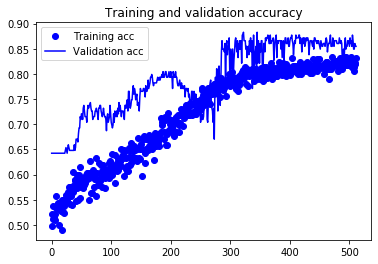

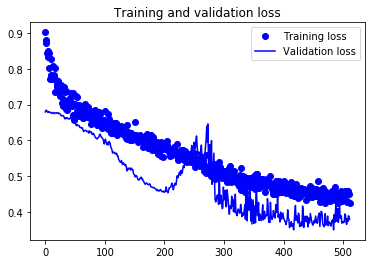

In [8]:
plot_history_info(training_history)

## Check the final accuracy

In [9]:
(test_loss, test_accuracy) = model.evaluate(test_x, test_y, batch_size=1)
print("Test accuracy: {}".format(test_accuracy))

418/418 [==============================] - 1s 2ms/sample - loss: 0.3123 - accuracy: 0.9019
Test accuracy: 0.9019138813018799
